In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled)


In [2]:
%matplotlib inline
import utils_modified; reload(utils_modified)
from utils_modified import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
import numpy as np
import random
import sys

In [4]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Embedding, Activation, merge, Flatten, Dropout, Lambda
from keras.layers import LSTM, SimpleRNN
from keras.models import Model, Sequential
from keras.engine.topology import Merge
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.convolutional import *
from keras.utils.data_utils import get_file

In [5]:
import quandl # pip install quandl
import pandas as pd

In [6]:
# https://keras.io/getting-started/sequential-model-guide/

In [103]:
nbassets = 9

In [249]:
def builder():
    # data array : 20days x 15stocks
    # note that we can name any layer by passing it a "name" argument.
    #main_input = Input(shape=(20,9), dtype='float32', name='main_input')
    
    model = Sequential()
    
    model.add( Dense(output_dim=100, input_shape=(20,nbassets), activation='tanh') )
    
    #model.add( BatchNormalization() )

    # a LSTM will transform the vector sequence into a single vector,
    # containing information about the entire sequence
    model.add( SimpleRNN(30,
                         return_sequences=False, stateful=False,
                         activation='relu', inner_init='identity') )
    
    #model.add( Dropout(0.5) )

    model.add( Dense(30, activation='tanh') )
    
    model.add( Dense(1, activation='relu') )
    
    model.compile(optimizer=Adam(1e-3), loss='mean_squared_error')
    
    return model

In [277]:
model1 = builder() # will be trained on simulated data

In [278]:
model1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_50 (Dense)                 (None, 20, 100)       1000        dense_input_22[0][0]             
____________________________________________________________________________________________________
simplernn_22 (SimpleRNN)         (None, 30)            3930        dense_50[0][0]                   
____________________________________________________________________________________________________
dense_51 (Dense)                 (None, 30)            930         simplernn_22[0][0]               
____________________________________________________________________________________________________
dense_52 (Dense)                 (None, 1)             31          dense_51[0][0]                   
Total params: 5,891
Trainable params: 5,891
Non-trainable params: 0
_______________________

In [279]:
if False:
    X = np.random.random((50,20,nbassets))
    Y = np.random.random((50,1))
else:
    AllXs = []
    AllYs = []
    for i in range(1000):
        t = (np.random.rand()-0.5)*6*5 # an offset for the sinus model
        Xs = []
        for stp in range(20):
            vol = 2 + math.sin(t+stp*0.2) # a market volatility
            Xs.append( np.random.randn(1,1,nbassets)*vol ) # one slice of stock returns
        futurevol = 2 + math.sin(t+(20-1+5)*0.2)
        #print(vol, nextvol)
        AllXs.append( np.concatenate(Xs, axis=1) )
        AllYs.append( np.array([futurevol]).reshape((1,1)) )
    X = np.concatenate(AllXs, axis=0)
    Y = np.concatenate(AllYs, axis=0)

In [283]:
model1.fit(X, Y, batch_size=50, nb_epoch=80, validation_split=0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/80
800/800 [==============================] - 0s - loss: 0.0050 - val_loss: 0.1829
Epoch 2/80
800/800 [==============================] - 0s - loss: 0.0041 - val_loss: 0.1838
Epoch 3/80
800/800 [==============================] - 0s - loss: 0.0043 - val_loss: 0.1905
Epoch 4/80
800/800 [==============================] - 0s - loss: 0.0040 - val_loss: 0.1830
Epoch 5/80
800/800 [==============================] - 0s - loss: 0.0039 - val_loss: 0.1836
Epoch 6/80
800/800 [==============================] - 0s - loss: 0.0038 - val_loss: 0.1865
Epoch 7/80
800/800 [==============================] - 0s - loss: 0.0034 - val_loss: 0.1893
Epoch 8/80
800/800 [==============================] - 0s - loss: 0.0033 - val_loss: 0.1835
Epoch 9/80
800/800 [==============================] - 0s - loss: 0.0033 - val_loss: 0.1882
Epoch 10/80
800/800 [==============================] - 0s - loss: 0.0031 - val_loss: 0.1907
Epoch 11/80
800/800 [======================

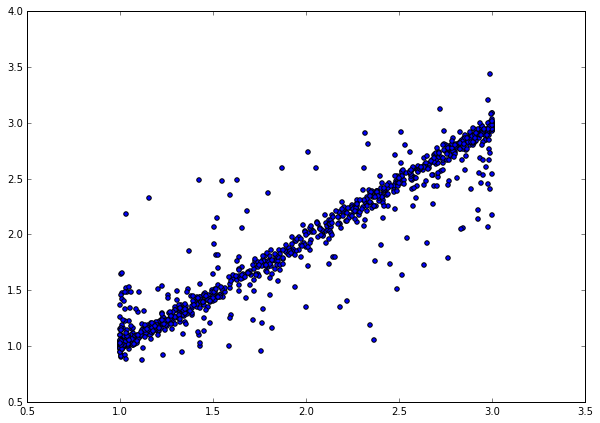

In [284]:
P = model1.predict(X)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(Y, P)
#plt.plot(Y)
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['without BN','with BN'], loc='upper right')
plt.show()

In [131]:
def qData(tick='XLU'):
    # GOOG/NYSE_XLU.4
    # WIKI/MSFT.4
    qtck = "GOOG/NYSE_"+tick+".4"
    return quandl.get(qtck,
                      start_date="2003-01-01",
                      end_date="2016-12-31",
                      collapse="daily")

In [132]:
'''TICKERS = ['MSFT','JPM','INTC','DOW','KO',
             'MCD','CAT','WMT','MMM','AXP',
             'BA','GE','XOM','PG','JNJ']'''
TICKERS = ['XLU','XLF','XLK','XLY','XLV','XLB','XLE','XLP','XLI']

In [133]:
try:
    D.keys()
except:
    print('create empty Quandl cache')
    D = {}

for tckr in TICKERS:
    if not(tckr in D.keys()):
        print(tckr)
        qdt = qData(tckr)
        qdt.rename(columns={'Close': tckr}, inplace = True)
        D[tckr] = qdt
        
for tck in D.keys():
    assert(D[tck].keys() == [tck])

XLU
XLF
XLK
XLY
XLV
XLB
XLE
XLP
XLI


In [134]:
for tck in D.keys():
    print(D[tck].shape)

(3538, 1)
(3538, 1)
(3538, 1)
(3538, 1)
(3538, 1)
(3538, 1)
(3538, 1)
(3538, 1)
(3538, 1)


In [135]:
J = D[TICKERS[0]].join(D[TICKERS[1]])
for tck in TICKERS[2:]:
    J = J.join(D[tck])

In [136]:
J.head(5)

,XLU,XLF,XLK,XLY,XLV,XLB,XLE,XLP,XLI
Date,,,,,,,,,
2003-01-02,19.60,22.80,15.60,23.98,27.27,20.36,22.80,20.32,21.12
2003-01-03,19.80,22.78,15.66,23.43,27.55,20.25,22.76,20.30,21.19
2003-01-06,20.69,23.55,16.35,23.86,27.85,20.64,22.95,20.45,21.38
2003-01-07,20.24,23.29,16.52,23.73,27.45,20.57,22.20,20.27,21.26
2003-01-08,20.38,23.05,15.98,23.51,27.24,20.04,21.99,20.15,21.00


In [137]:
J.isnull().sum()

XLU    0
XLF    0
XLK    0
XLY    0
XLV    0
XLB    0
XLE    0
XLP    0
XLI    0
dtype: int64

In [138]:
J2 = J.fillna(method='ffill')
#J2[J['WMT'].isnull()]

In [139]:
LogDiffJ = J2.apply(np.log).diff(periods=1, axis=0)
LogDiffJ.drop(LogDiffJ.index[0:1], inplace=True)
LogDiffJ.shape

(3537, 9)

In [140]:
MktData = LogDiffJ.as_matrix(columns=None) # as numpy.array
MktData.shape

(3537, 9)

In [250]:
model2 = builder() # will be trained on market data

In [251]:
if True:
    AllXs = []
    AllYs = []
    for i in range(500):
        t = np.random.randint(50, MktData.shape[0]-100) # an offset for whole historics
        Xs = []
        for stp in range(20):
            Xs.append( MktData[t+stp,:].reshape(1,1,-1)*100 ) # one slice of stock returns
        futurevol = math.sqrt(np.sum(MktData[t+20:t+20+10,:]*MktData[t+20:t+20+10,:]))*100
        #print(futurevol)
        AllXs.append( np.concatenate(Xs, axis=1) )
        AllYs.append( np.array([futurevol]).reshape((1,1)) )
    X = np.concatenate(AllXs, axis=0)
    Y = np.concatenate(AllYs, axis=0)

In [252]:
X.shape, Y.shape

((500, 20, 9), (500, 1))

In [253]:
print(np.min(X), np.mean(X), np.max(X))
print(np.min(Y), np.mean(Y), np.max(Y))

-18.2321556794 0.0221144715492 15.250350436
3.97565492944 11.8459606382 51.9805745241


In [254]:
Yc = np.clip(Y, 0, 3*np.mean(Y))
np.mean(Y), np.mean(Yc)

(11.845960638187094, 11.688729323447399)

In [255]:
# WARNING : need to scale data to speed up training !!!
factorX = 0.20
factorY = 0.10

## WARNING : **VALIDATION** should be posterior only

In [270]:
# seems like 150 epochs are required to converge : BUG ?
model2.optimizer.lr = 1e-4
model2.fit(factorX*X, factorY*Yc, batch_size=50, nb_epoch=25, validation_split=0.2)

Train on 400 samples, validate on 100 samples
Epoch 1/25
400/400 [==============================] - 0s - loss: 0.0117 - val_loss: 0.0516
Epoch 2/25
400/400 [==============================] - 0s - loss: 0.0119 - val_loss: 0.0519
Epoch 3/25
400/400 [==============================] - 0s - loss: 0.0112 - val_loss: 0.0504
Epoch 4/25
400/400 [==============================] - 0s - loss: 0.0108 - val_loss: 0.0523
Epoch 5/25
400/400 [==============================] - 0s - loss: 0.0105 - val_loss: 0.0489
Epoch 6/25
400/400 [==============================] - 0s - loss: 0.0111 - val_loss: 0.0509
Epoch 7/25
400/400 [==============================] - 0s - loss: 0.0112 - val_loss: 0.0500
Epoch 8/25
400/400 [==============================] - 0s - loss: 0.0107 - val_loss: 0.0513
Epoch 9/25
400/400 [==============================] - 0s - loss: 0.0103 - val_loss: 0.0500
Epoch 10/25
400/400 [==============================] - 0s - loss: 0.0099 - val_loss: 0.0500
Epoch 11/25
400/400 [======================

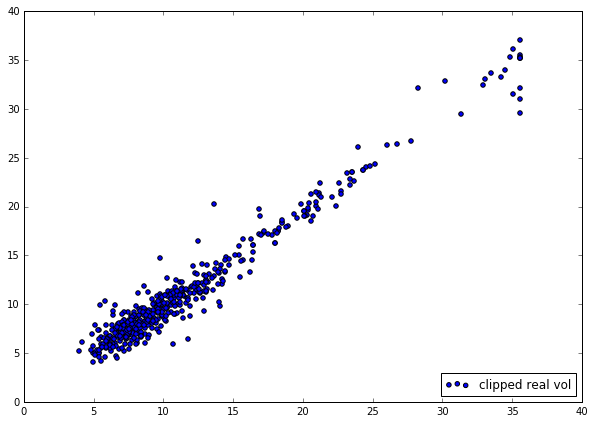

In [273]:
P = model2.predict(factorX*X)/factorY

import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(Yc, P)
#plt.plot(Y)
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
plt.legend(['clipped real vol','model vol'], loc='lower right')
plt.show()